In [ ]:
from keras.models import load_model
from IPython.display import Audio
import tensorflow as tf
import numpy as np
import librosa
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt
from scripts.nocle import *

f:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = load_model('model/first.hdf5')
# model = load_model('model/lstm2.hdf5')


In [3]:
index = 40

noisy_audio_path = f'test/noisy_testset_wav/{index}.wav'  # Tahmin yapmak istediğiniz dosyanın yolu
clean_audio_path = f'test/clean_testset_wav/{index}.wav'  # Tahmin yapmak istediğiniz dosyanın yolu
dd = "1.wav"

original_audio = get_audio(clean_audio_path)

Audio(original_audio, rate=16000)


In [4]:

noisy_audio = get_audio(dd)

Audio(noisy_audio, rate=16000)


In [17]:
pred = predict4(dd, model, 
               batching_size=12000, 
               noise_reduce=False,
               gate=True,
               smooth=True,
               extra_filter=True,
               params=[15,1]
               )

# pred2 = predict_tflite(noisy_audio_path, 'model/quantized_model.tflite', batching_size=12000)
Audio(pred,rate=16000)


In [ ]:
Audio(pred,rate=16000)


In [7]:
Audio(pred2,rate=16000)


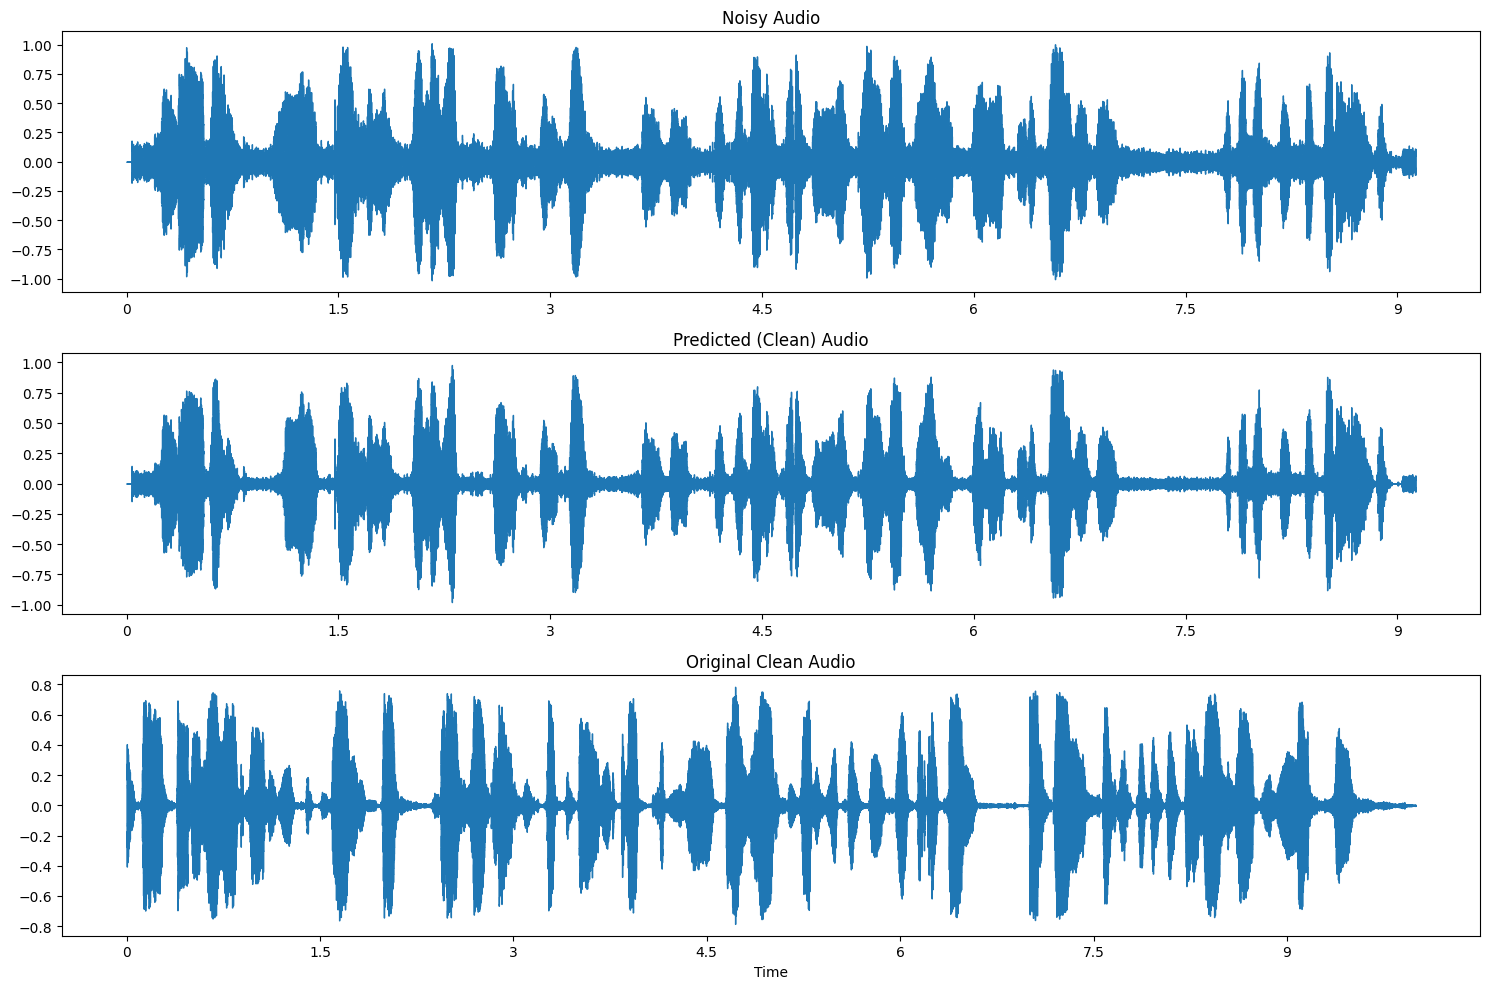

In [16]:
import matplotlib.pyplot as plt
import librosa.display

def plot_waveforms(noisy_path, predicted_audio, clean_path=None):
    # Load audio files
    noisy_audio = get_audio(noisy_path)
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    
    # Plot noisy audio
    librosa.display.waveshow(noisy_audio, sr=16000, ax=axes[0])
    axes[0].set_title('Noisy Audio')
    axes[0].set_xlabel('')
    
    # Plot predicted audio
    librosa.display.waveshow(predicted_audio, sr=16000, ax=axes[1])
    axes[1].set_title('Predicted (Clean) Audio')
    axes[1].set_xlabel('')
    
    # Plot clean audio if provided
    if clean_path:
        clean_audio = get_audio(clean_path)
        librosa.display.waveshow(clean_audio, sr=16000, ax=axes[2])
        axes[2].set_title('Original Clean Audio')
    
    plt.tight_layout()
    plt.show()

# Usage:
# noisy_path = "test/noisy_testset_wav/1.wav"
clean_path = "test/clean_testset_wav/1.wav"  # Optional
# predicted = predict(noisy_path, model)
plot_waveforms(noisy_audio_path, pred, clean_path)

In [7]:
import noisereduce as nr
from scipy import signal

def enhance_audio_quality(audio_data, sr=16000):
    """
    Enhanced audio processing using noisereduce library
    """
    # Apply noise reduction
    reduced_noise = nr.reduce_noise(
        y=audio_data,
        sr=sr,
        prop_decrease=0.75,
        n_fft=2048,
        win_length=2048,
        hop_length=256,
        stationary=True
    )
    
    return reduced_noise

def bass_boost(data, boost_db=6.0, cutoff_freq=200):
    """
    Boost bass frequencies while maintaining clean highs
    - boost_db: amount of boost in dB
    - cutoff_freq: frequency below which to apply boost
    """
    # Design low shelf filter
    nyq = 16000 / 2.0
    norm_cutoff = cutoff_freq / nyq
    boost_factor = 10.0 ** (boost_db / 20.0)
    
    # Create butterworth filter
    b, a = signal.butter(2, norm_cutoff, btype='lowpass')
    
    # Split into low and high frequencies
    low = signal.filtfilt(b, a, data)
    high = data - low
    
    # Apply boost to low frequencies
    boosted_low = low * boost_factor
    
    # Combine and normalize
    result = boosted_low + high
    return result / np.max(np.abs(result))



aud = enhance_audio_quality(pred)
aud = bass_boost(aud, boost_db=6.0, cutoff_freq=200)
Audio(aud, rate=16000)

f:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Save Prediction

In [ ]:
# Save the predicted audio
librosa.output.write_wav(f'predicted_{index}.wav', pred, sr=16000)

In [15]:
from sklearn.metrics import mean_absolute_error

def calculate_snr(original, denoised):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - denoised) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Calculate SNR
snr = calculate_snr(noisy_audio, pred)
print(f'SNR: {snr} dB')

# Calculate MAE
# mae = mean_absolute_error(original_audio, pred)
# print(f'MAE: {mae}')

SNR: 10.701324462890625 dB
